In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from scipy import optimize
%matplotlib inline

In [2]:
np.random.seed(228)

# Gradient descent method
Since matrix $P$ is given in the problem statement, we will set it uniformly distributed. 
Let $n = 4$ and $m = 5$.

In [3]:
n = 4
m = 5

P = np.array([np.random.uniform(size=n) for x in np.zeros(m)])
P /= P.sum(axis=0) # sum of columns must be 1
c_t = np.array([-np.sum(x * np.log2(x)) for x in P.T])

print(P)

[[ 0.30041621  0.15293965  0.27373994  0.23441303]
 [ 0.31120355  0.16629472  0.25986809  0.07468655]
 [ 0.10129585  0.24678942  0.13397748  0.04678755]
 [ 0.22110249  0.17299438  0.26001888  0.61089725]
 [ 0.0659819   0.26098183  0.07239561  0.03321562]]


Here there is implementation of function from the task and its gradient. For the gradient descent method we should  calculate projection on a probability simplex for every given point, because we have such constraints in the task.

In [4]:
def euclidean_proj_simplex(v, s=1):
    n, = v.shape  
    if v.sum() == s and np.alltrue(v >= 0):
        return v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    theta = (cssv[rho] - s) / (rho + 1.0)
    w = (v - theta).clip(min=0)
    return w

def f(x):
    #get projection of x
    x_ = euclidean_proj_simplex(x)
    y = P @ x_
    if (np.min(y) <= 0):
        return np.inf
    return c_t @ x_ + np.sum(y * np.log(y) / np.log(2))

def grad_f(x):
    #get projection of x
    x_ = euclidean_proj_simplex(x)
    y = P @ x_
    if (np.min(y) <= 0):
        raise ValueError
    grad = c_t.copy()
    tmp = []
    for i in range(m):
        tmp.append(P[i] * (np.log(P[i] @ x_) + 1) / np.log(2))
    tmp_sum = np.sum(np.array(tmp), axis=0)
    return grad + tmp_sum

Then, we need to implement a stopping criteria and different algorithms for step calculation of our method.

In [5]:
class StoppingCriteria:
    def __init__(self, max_iterations=np.inf, min_grad_norm=0, min_norm_step=0, min_f_norm=(np.inf, 0)):
        """min_f_norm = (f_true, min|f - f_true| to stop)"""
        self.max_iterations = max_iterations
        self.min_grad_norm = min_grad_norm
        self.min_norm_step = min_norm_step
        self.f_min = min_f_norm[0]
        self.min_f_norm = min_f_norm[1]
    
    def __call__(self, state):
        cur_iterations = state['iterations']
        cur_grad_norm = np.linalg.norm(state['cur_grad'], ord=2)
        dif_x = np.linalg.norm(state['x'] - state['prev_x'], ord=2)
        f_norm = np.abs(self.f_min - state['f'](state['x']))
        return (cur_iterations >= self.max_iterations or cur_grad_norm <= self.min_grad_norm 
                or dif_x <= self.min_norm_step or f_norm <= self.min_f_norm)

In [6]:
class StepSearchFastestTernary:
    def __init__(self, precision, init_kpower=-2):
        self.precision = precision
        self.left = 0
        self.right = None
        self.init_kpower = init_kpower
        
    def __update_starting_points(self, state):
        k_power = self.init_kpower
        f = state['f']
        x = state['x']
        dx = state['dx']
        while f(x + 2**k_power * dx) > f(x + 2**(k_power + 1) * dx):
            k_power += 1
        if k_power == self.init_kpower:
            self.left = 0
        else:
            self.left = 2**(k_power - 1)
        self.right = 2**(k_power + 1)
            
            
    def __call__(self, state):
        f = state['f']
        x = state['x']
        dx = state['dx']
        
        self.__update_starting_points(state) # update self.left and self.right
        
        right = self.right
        left = self.left
        
        while True:
            if abs(right - left) < self.precision:
                return (left + right)/2

            left_div = left + (right - left)/3
            right_div = right - (right - left)/3

            f_left = f(x + left_div * dx)
            f_right = f(x + right_div * dx)
            
            if f_left == np.inf:
                right = right_div
            else:
                if f_left < f_right:
                    right = right_div
                else:
                    left = left_div

In [7]:
class StepSearchBacktracking:
    def __init__(self, alpha=0.3, beta=0.7):
        self.alpha = alpha
        self.beta = beta
            
    def __call__(self, state):
        t = 1
        f = state['f']
        grad_f = state['grad_f']
        x = state['x']
        dx = state['dx']
        grad_proj = euclidean_proj_simplex(grad_f(x))
        
        while f(x + t * dx) > f(x) + self.alpha * t * grad_proj.T @ dx:
            t *= self.beta
        return t

In [8]:
class StepSearchConstant:
    def __init__(self, lr):
        self.lr = lr
            
    def __call__(self, state):
        return self.lr  

Now we are ready to implement the gradient descent method.

In [9]:
class GradientDescentMethod:
    def __init__(self, t_search, stopping_criteria):
        self.t_search = t_search
        self.stopping_criteria = stopping_criteria
    
    def minimize(self, f, grad_f, x_0, f_min_true=np.inf):
        x = x_0.copy()
        
        state = dict()
        state['f'] = f
        state['grad_f'] = grad_f
        state['x'] = x
        # hardcoded xD
        state['prev_x'] = np.ones(n) / n
        
        state['iterations'] = 0
        state['time'] = time.time()
        state['steps_norms'] = []
        state['time_array'] = []
        state['f_true_norms'] = []
        while True:
            state['cur_grad'] = grad_f(state['x'])
            state['dx'] = -grad_f(state['x'])
            
            if self.stopping_criteria(state):
                break
            t = self.t_search(state)
            
            state['prev_x'] = state['x'].copy()
            state['x'] -= t * state['cur_grad']
            #take projection on simplex
            state['x'] = euclidean_proj_simplex(state['x'])
            
            state['steps_norms'].append(np.linalg.norm(state['x'] - state['prev_x'], ord=2))
            state['f_true_norms'].append(np.abs(f(state['x']) - f_min_true))
            state['time_array'].append(time.time() - state['time'])
            state['iterations'] += 1
            
        state['time'] = time.time() - state['time']
        return state

In [10]:
def draw_plots(states, method_names, x_axis='time', y_axis='step'):
    x_title = 'time, ms'
    y_title = r'$||step||_2$'
    
    if x_axis != 'time':
        x_title = 'iterations'
        
    if y_axis != 'step':
        y_title = r'$||f - f_true||$'
    
    plt.figure(figsize=(18, 10))
    plt.grid(True)
    plt.title('{} norm({})'.format(y_axis, x_title))
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    for state, name in zip(states, method_names):
        xx = None
        if x_axis == 'time':
            xx = state['time_array']
        else:
            xx = np.arange(1, len(state['steps_norms']) + 1)
        
        yy = None
        if y_axis == 'step':
            yy = state['steps_norms']
        else:
            yy = state['f_true_norms']
            
        plt.semilogy(xx, yy, label=name)
    plt.legend()
#     plt.savefig('gradient_descent_time.png')
    plt.show()
    

Let's choose a starting point and calculate minimum with a very high accuracy.

In [11]:
x_0 = np.random.uniform(low=0, high=1, size=n)
x_0 /= np.sum(x_0)

In [12]:
stopping_criteria = StoppingCriteria(min_norm_step=1e-15)
t_search = StepSearchConstant(lr=0.01)
grad = GradientDescentMethod(t_search=t_search, stopping_criteria=stopping_criteria)
state = grad.minimize(f, grad_f, x_0)
print('x_0 = ', x_0)
print('f_min ={:.16f}'.format(f(state['x'])))
print('time = ', state['time'])
print("iterations = ", state['iterations'])
print('x = ',state['x'])

f_min = f(state['x'])

x_0 =  [ 0.15650363  0.11312269  0.27314528  0.4572284 ]
f_min =-0.2423865917883412
time =  2.3851208686828613
iterations =  6123
x =  [ 0.09836678  0.42498952  0.          0.47664371]


Here we compare different step calculation methods.

In [13]:
search_methods = [StepSearchFastestTernary(precision=1e-9, init_kpower=-4),
                  StepSearchConstant(lr=0.5),
                  StepSearchConstant(lr=0.1),
                  StepSearchConstant(lr=1.2),
                  StepSearchConstant(lr=2.2),
                  StepSearchBacktracking(alpha=1e-8, beta=0.5),
                  StepSearchBacktracking(alpha=1e-9, beta=0.3)]
method_names = ['Ternary', 'Constant, lr=0.5', 'Constant, lr=0.1', 'Constant, lr=1.2', 'Constant, lr=2.2',
                r'Backtracking, $\alpha$=1e-8, $\beta=0.5$', 
                r'Backtracking, $\alpha$=1e-9, $\beta=0.3$']
stopping_criteria = StoppingCriteria(min_f_norm=(f_min, 1e-8), max_iterations=150)

states = []
for t_search in search_methods:
    grad = GradientDescentMethod(t_search=t_search, stopping_criteria=stopping_criteria)
    state = grad.minimize(f, grad_f, x_0, f_min_true=f_min)
    states.append(state)

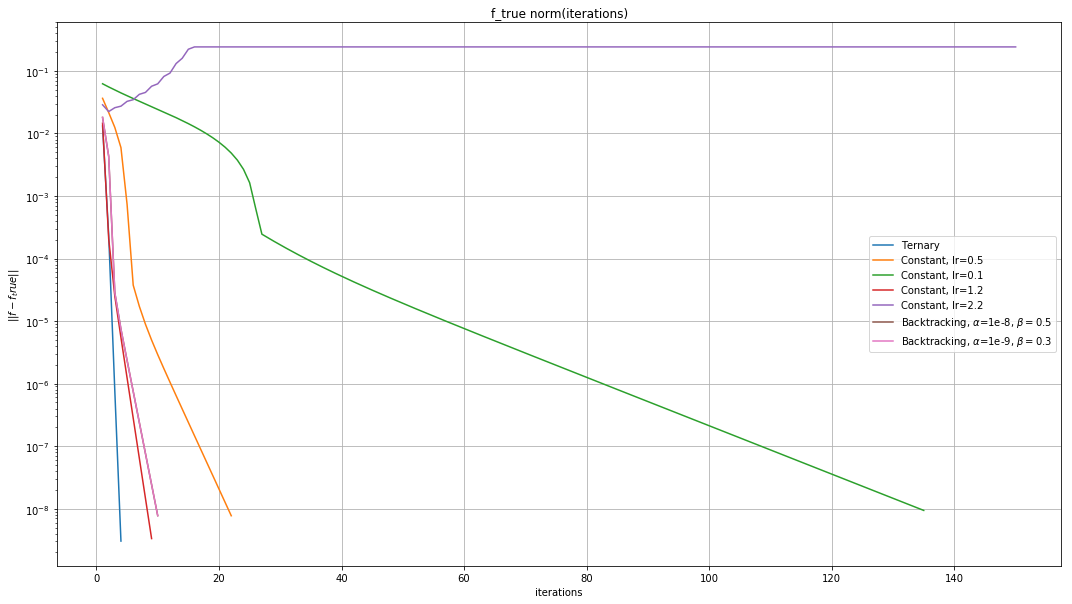

In [14]:
draw_plots(states, method_names, x_axis='iter', y_axis='f_true')

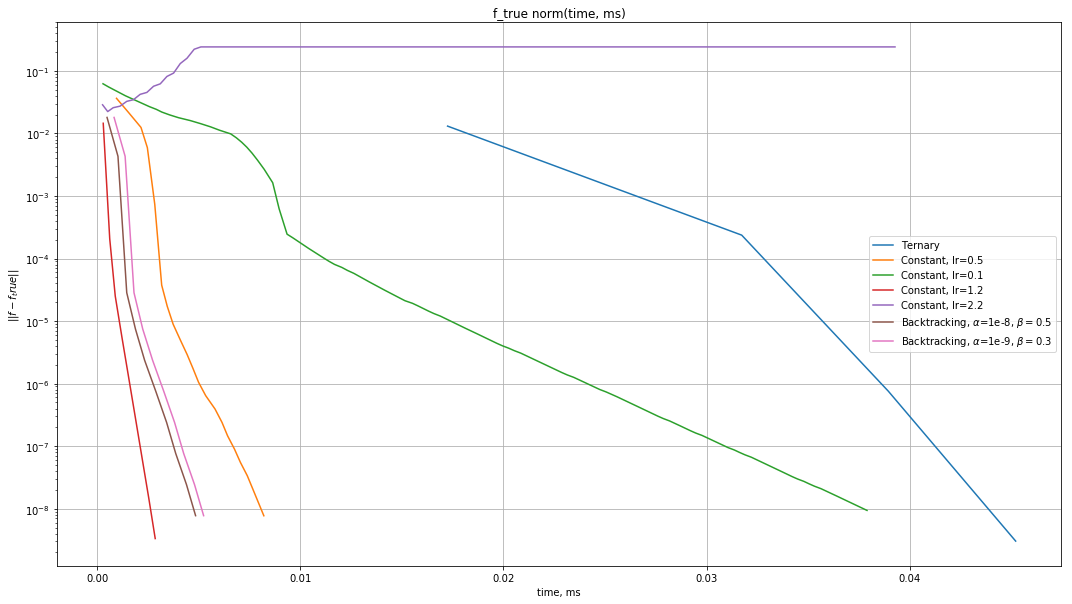

In [15]:
draw_plots(states, method_names, x_axis='time', y_axis='f_true')

Here we can see, that we have found minimum correctly, and even better than **scipy.optimize.minimize**.

In [18]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: x[2]},
       {'type': 'ineq', 'fun': lambda x: x[3]})

In [19]:
print(optimize.minimize(f, x_0, method='SLSQP',
               constraints=cons).fun)

print(f_min)

-0.24238659096848902
-0.242386591788
